# Imports

In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Data

In [2]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Dictionary

- **PassengerID** - A column added by Kaggle to identify each row and make submissions easier
- **Survived** - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
- **Pclass** - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
- **Sex** - The passenger's sex
- **Age** - The passenger's age in years
- **SibSp** - The number of siblings or spouses the passenger had aboard the Titanic
- **Parch** - The number of parents or children the passenger had aboard the Titanic
- **Ticket** - The passenger's ticket number
- **Fare** - The fare the passenger paid
- **Cabin** - The passenger's cabin number
- **Embarked** - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

# Explore

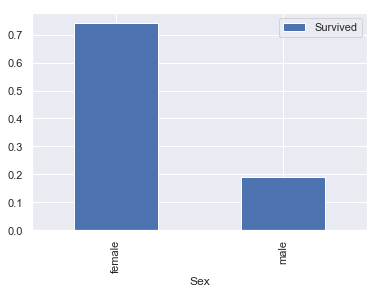

In [30]:
train.pivot_table(index='Sex', values='Survived').plot.bar();

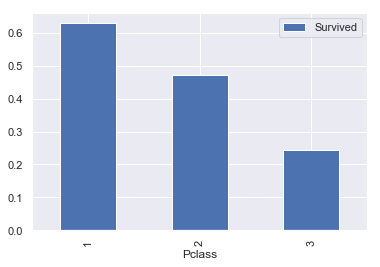

In [29]:
train.pivot_table(index="Pclass", values="Survived").plot.bar();

In [10]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

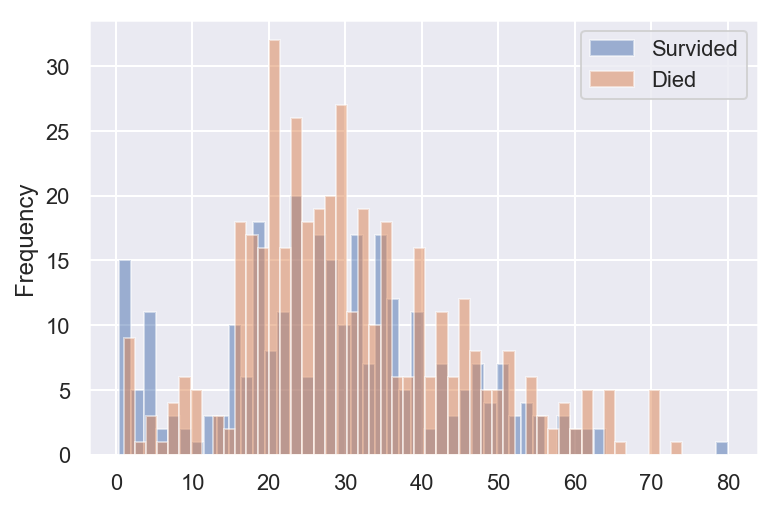

In [34]:
survived = train[train['Survived'] == 1]
died = train[~(train['Survived'] == 1)]

for status in [survived, died]:
    status['Age'].plot.hist(alpha=0.5, bins=50)
plt.legend(['Survided', 'Died']);

# Feature engineering

## Ages

In [36]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

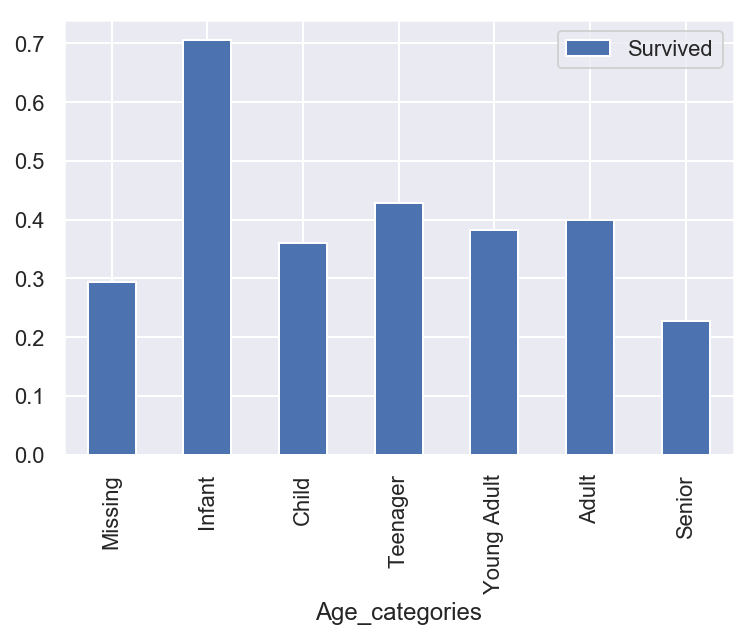

In [37]:
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

train.pivot_table(index="Age_categories", values="Survived").plot.bar();

## Make dummies

In [38]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [40]:
for col in ["Pclass", "Sex", "Age_categories"]:
    train = create_dummies(train, col)
    test = create_dummies(test, col)

# Model

In [43]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

In [44]:
lr = LogisticRegression()
lr.fit(train[columns], train['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.20,random_state=0)

In [49]:
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(predictions, test_y)
accuracy

0.8100558659217877

In [52]:
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = np.mean(scores)
accuracy

0.8024670865963002

## Test on holdout

In [58]:
holdout = test.copy()
lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[columns])

## Solutions

In [59]:
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

In [60]:
submission.to_csv('submission.csv', index=False)